# 02 — Modeling

Model training and evaluation notebook for S2Cool using preprocessed data (default) with optional raw DB refetch.

In [8]:
# CELL 1: Data Source Selection (default: local processed CSV, optional DB refetch)
from __future__ import annotations

import os
from pathlib import Path
from typing import Final

import pandas as pd

REFETCH_FROM_DB: Final[bool] = False
PROCESSED_BACKUP_PATH: Final[Path] = Path("data/s2cool_features_ready.csv")

raw_df: pd.DataFrame | None = None
processed_for_csv: pd.DataFrame | None = None

if (not REFETCH_FROM_DB) and PROCESSED_BACKUP_PATH.exists():
    processed_for_csv = pd.read_csv(PROCESSED_BACKUP_PATH)
    if processed_for_csv.empty:
        raise ValueError(f"Processed CSV exists but is empty: {PROCESSED_BACKUP_PATH}")

    if "Timestamp" not in processed_for_csv.columns:
        raise KeyError("Processed CSV must include a 'Timestamp' column.")

    processed_for_csv["Timestamp"] = pd.to_datetime(
        processed_for_csv["Timestamp"], errors="coerce", utc=True
    )
    if processed_for_csv["Timestamp"].isna().any():
        raise ValueError("Failed to parse one or more Timestamp values from processed CSV.")

    print(f"Loaded existing processed data from: {PROCESSED_BACKUP_PATH}")
    print(f"Processed CSV shape: {processed_for_csv.shape}")
else:
    from dotenv import load_dotenv
    from sqlalchemy import create_engine, text
    from sqlalchemy.engine import Engine
    from sqlalchemy.exc import SQLAlchemyError

    load_dotenv()
    database_url: str | None = os.getenv("DATABASE_URL") or os.getenv("NEON_DB_URL")
    if not database_url:
        raise RuntimeError("Missing required environment variable: DATABASE_URL or NEON_DB_URL")

    def create_db_engine(db_url: str) -> Engine:
        """Create SQLAlchemy engine with pool health checks."""
        return create_engine(db_url, pool_pre_ping=True)

    def detect_weather_table(engine: Engine) -> str:
        """Detect expected weather table name in current schema."""
        query = text(
            """
            SELECT table_name
            FROM information_schema.tables
            WHERE table_schema = 'public'
              AND table_name IN ('solar_weather_data', 'weather_data')
            ORDER BY CASE WHEN table_name = 'solar_weather_data' THEN 0 ELSE 1 END
            LIMIT 1;
            """
        )
        with engine.connect() as connection:
            table_name = connection.execute(query).scalar_one_or_none()
        if table_name is None:
            raise RuntimeError(
                "No expected weather table found. Expected one of: solar_weather_data, weather_data"
            )
        return str(table_name)

    def fetch_raw_weather_dataframe(engine: Engine, table_name: str) -> pd.DataFrame:
        """Fetch normalized weather columns ordered by city and timestamp."""
        if table_name == "solar_weather_data":
            query = text(
                """
                SELECT
                    timestamp AS \"Timestamp\",
                    city_name AS \"City\",
                    shortwave_radiation AS \"GHI\",
                    temperature_2m AS \"Ambient_Temp\"
                FROM solar_weather_data
                ORDER BY city_name ASC, timestamp ASC;
                """
            )
        else:
            query = text(
                """
                SELECT
                    timestamp AS \"Timestamp\",
                    city AS \"City\",
                    ghi AS \"GHI\",
                    ambient_temp AS \"Ambient_Temp\"
                FROM weather_data
                ORDER BY city ASC, timestamp ASC;
                """
            )

        with engine.connect() as connection:
            return pd.read_sql_query(query, con=connection)

    try:
        db_engine = create_db_engine(database_url)
        table_name = detect_weather_table(db_engine)
        print(f"Using source table: {table_name}")
        raw_df = fetch_raw_weather_dataframe(db_engine, table_name)
    except SQLAlchemyError as exc:
        raise RuntimeError(
            "Database connection/query failed for weather extraction."
        ) from exc

    if raw_df.empty:
        raise ValueError("Weather query returned zero rows.")

    print(f"Raw dataframe shape: {raw_df.shape}")
    print("Raw dataframe columns:", list(raw_df.columns))

if raw_df is not None:
    raw_df.head()
else:
    processed_for_csv.head()

Loaded existing processed data from: data\s2cool_features_ready.csv
Processed CSV shape: (35640, 24)


In [9]:
# CELL 2: Preprocessing Integration (only when raw DB data is fetched)
from preprocessing import S2CoolDataPreprocessor

if raw_df is not None:
    required_columns = {"Timestamp", "City", "GHI", "Ambient_Temp"}
    column_mapping = {
        "timestamp": "Timestamp",
        "city": "City",
        "ghi": "GHI",
        "ambient_temp": "Ambient_Temp",
        "temperature_2m": "Ambient_Temp",
        "shortwave_radiation": "GHI",
    }
    normalized_raw_df = raw_df.rename(columns=column_mapping).copy()
    missing_after_map = required_columns - set(normalized_raw_df.columns)
    if missing_after_map:
        raise KeyError(f"Missing required columns after normalization: {sorted(missing_after_map)}")

    processor = S2CoolDataPreprocessor(
        scaler_path=Path("artifacts/s2cool_standard_scaler.joblib")
    )
    processed_df = processor.process_pipeline(normalized_raw_df)

    processed_backup_path = Path("data/s2cool_features_ready.csv")
    processed_backup_path.parent.mkdir(parents=True, exist_ok=True)
    processed_for_csv = processed_df.reset_index().rename(columns={"index": "Timestamp"})
    processed_for_csv.to_csv(processed_backup_path, index=False)

    print(f"Processed dataframe shape: {processed_df.shape}")
    print(f"Saved processed backup to: {processed_backup_path}")
else:
    if processed_for_csv is None:
        raise RuntimeError("No data available for modeling. Enable REFETCH_FROM_DB or provide processed CSV.")

    processed_df = processed_for_csv.copy()
    processed_df["Timestamp"] = pd.to_datetime(processed_df["Timestamp"], errors="coerce", utc=True)
    if processed_df["Timestamp"].isna().any():
        raise ValueError("Timestamp parsing failed for processed CSV loaded in CELL 1.")

    processed_df = processed_df.set_index("Timestamp")
    print(f"Using preprocessed dataframe from local CSV. Shape: {processed_df.shape}")

processed_df.head()

Using preprocessed dataframe from local CSV. Shape: (35640, 23)


,City,GHI,Ambient_Temp,day_of_year,hour_sin,hour_cos,month_sin,month_cos,GHI_lag_1,GHI_lag_2,...,Ambient_Temp_lag_1,Ambient_Temp_lag_2,Ambient_Temp_lag_3,Ambient_Temp_lag_24,Ambient_Temp_lag_48,GHI_rolling_mean_3h,GHI_rolling_std_3h,Temp_rolling_mean_6h,Target_GHI_next_1h,Target_Temp_next_1h
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-22 00:00:00+00:00,Islamabad,0.0,-1.659441,53,0.965926,2.588190e-01,0.866025,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,10.7
2025-02-22 01:00:00+00:00,Islamabad,0.0,-1.597798,53,1.000000,6.123234e-17,0.866025,0.5,-0.741132,NaN,...,-1.659378,NaN,NaN,NaN,NaN,-0.770299,NaN,-1.700462,1.0,10.2
2025-02-22 02:00:00+00:00,Islamabad,1.0,-1.659441,53,0.965926,-2.588190e-01,0.866025,0.5,-0.741132,-0.741049,...,-1.597738,-1.659365,NaN,NaN,NaN,-0.770299,-0.898652,-1.668876,80.0,11.6
2025-02-22 03:00:00+00:00,Islamabad,80.0,-1.486841,53,0.866025,-5.000000e-01,0.866025,0.5,-0.737414,-0.741049,...,-1.659378,-1.597727,-1.659444,NaN,NaN,-0.769010,-0.890024,-1.679405,252.0,14.6
2025-02-22 04:00:00+00:00,Islamabad,252.0,-1.116984,53,0.707107,-7.071068e-01,0.866025,0.5,-0.443646,-0.737330,...,-1.486786,-1.659365,-1.597807,NaN,NaN,-0.665931,-0.212657,-1.640448,431.0,17.0


In [10]:
# CELL 3: Strict Time-Series Splitting (both targets)
target_columns = ["Target_GHI_next_1h", "Target_Temp_next_1h"]

processed_sorted = processed_df.reset_index().rename(columns={"index": "Timestamp"}).copy()
processed_sorted["Timestamp"] = pd.to_datetime(processed_sorted["Timestamp"], errors="coerce", utc=True)
if processed_sorted["Timestamp"].isna().any():
    raise ValueError("Timestamp parsing failed in processed dataframe prior to split.")
processed_sorted = processed_sorted.sort_values("Timestamp").reset_index(drop=True)

missing_targets = [column for column in target_columns if column not in processed_sorted.columns]
if missing_targets:
    raise KeyError(f"Missing target columns for split: {missing_targets}")

X = processed_sorted.drop(columns=target_columns).copy()
y = processed_sorted[target_columns].copy()

# Convert feature columns to model-safe numeric matrix while preserving chronology.
if "Timestamp" in X.columns:
    X["Timestamp"] = pd.to_datetime(X["Timestamp"], utc=True).astype("int64") // 10**9
if "City" in X.columns:
    X["City"] = X["City"].astype("category")
    X = pd.get_dummies(X, columns=["City"], dtype=float)

X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)

split_index = int(len(X) * 0.8)
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

y_train_ghi = y_train["Target_GHI_next_1h"].to_numpy()
y_test_ghi = y_test["Target_GHI_next_1h"].to_numpy()
y_train_temp = y_train["Target_Temp_next_1h"].to_numpy()
y_test_temp = y_test["Target_Temp_next_1h"].to_numpy()

print(f"Chronologically sorted dataframe shape: {processed_sorted.shape}")
print(f"X shape: {X.shape} | y shape: {y.shape}")
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")
print(f"y_train_ghi shape: {y_train_ghi.shape} | y_test_ghi shape: {y_test_ghi.shape}")
print(f"y_train_temp shape: {y_train_temp.shape} | y_test_temp shape: {y_test_temp.shape}")

Chronologically sorted dataframe shape: (35640, 24)
X shape: (35640, 25) | y shape: (35640, 2)
X_train shape: (28512, 25) | X_test shape: (7128, 25)
y_train shape: (28512, 2) | y_test shape: (7128, 2)
y_train_ghi shape: (28512,) | y_test_ghi shape: (7128,)
y_train_temp shape: (28512,) | y_test_temp shape: (7128,)


In [11]:
# CELL 4: Model 1 - XGBoost (two targets)
from pathlib import Path

import joblib
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f"XGB train matrix shape: {X_train.shape}")
print(f"XGB test matrix shape: {X_test.shape}")

xgb_ghi = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)
xgb_temp = xgb.XGBRegressor(
    learning_rate=0.05,
    max_depth=5,
    n_estimators=200,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

xgb_ghi.fit(X_train, y_train_ghi)
xgb_temp.fit(X_train, y_train_temp)

xgb_ghi_preds = xgb_ghi.predict(X_test)
xgb_temp_preds = xgb_temp.predict(X_test)

xgb_ghi_mae = mean_absolute_error(y_test_ghi, xgb_ghi_preds)
xgb_ghi_rmse = float(np.sqrt(mean_squared_error(y_test_ghi, xgb_ghi_preds)))
xgb_temp_mae = mean_absolute_error(y_test_temp, xgb_temp_preds)
xgb_temp_rmse = float(np.sqrt(mean_squared_error(y_test_temp, xgb_temp_preds)))

print(f"XGBoost GHI  MAE: {xgb_ghi_mae:.4f} | RMSE: {xgb_ghi_rmse:.4f}")
print(f"XGBoost Temp MAE: {xgb_temp_mae:.4f} | RMSE: {xgb_temp_rmse:.4f}")

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

xgb_ghi_path = artifacts_dir / "xgboost_ghi_model.pkl"
xgb_temp_path = artifacts_dir / "xgboost_temp_model.pkl"
joblib.dump(xgb_ghi, xgb_ghi_path)
joblib.dump(xgb_temp, xgb_temp_path)

print(f"Saved XGBoost GHI model to:  {xgb_ghi_path}")
print(f"Saved XGBoost Temp model to: {xgb_temp_path}")

XGB train matrix shape: (28512, 25)
XGB test matrix shape: (7128, 25)
XGBoost GHI  MAE: 13.6723 | RMSE: 26.1027
XGBoost Temp MAE: 0.5280 | RMSE: 0.7874
Saved XGBoost GHI model to:  artifacts\xgboost_ghi_model.pkl
Saved XGBoost Temp model to: artifacts\xgboost_temp_model.pkl


In [15]:
# CELL 5: Model 2 - LSTM (two targets, sliding-window sequences)
from pathlib import Path

import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


def create_sequences(X_data, y_data, time_steps=24):
    X_values = X_data.to_numpy(dtype=np.float32)
    y_values = np.asarray(y_data, dtype=np.float32)

    if len(X_values) <= time_steps:
        raise ValueError(f"Not enough rows ({len(X_values)}) for time_steps={time_steps}")

    X_seq, y_seq = [], []
    for i in range(time_steps, len(X_values)):
        X_seq.append(X_values[i - time_steps : i])
        y_seq.append(y_values[i])

    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)


def build_lstm(input_shape):
    model = Sequential(
        [
            LSTM(64, return_sequences=False, input_shape=input_shape),
            Dropout(0.2),
            Dense(1),
        ]
    )
    model.compile(optimizer="adam", loss="mse")
    return model


X_train_seq_ghi, y_train_seq_ghi = create_sequences(X_train, y_train_ghi, time_steps=24)
X_test_seq_ghi, y_test_seq_ghi = create_sequences(X_test, y_test_ghi, time_steps=24)

X_train_seq_temp, y_train_seq_temp = create_sequences(X_train, y_train_temp, time_steps=24)
X_test_seq_temp, y_test_seq_temp = create_sequences(X_test, y_test_temp, time_steps=24)

print(f"X_train_seq_ghi shape: {X_train_seq_ghi.shape} | y_train_seq_ghi shape: {y_train_seq_ghi.shape}")
print(f"X_test_seq_ghi shape:  {X_test_seq_ghi.shape} | y_test_seq_ghi shape:  {y_test_seq_ghi.shape}")
print(f"X_train_seq_temp shape: {X_train_seq_temp.shape} | y_train_seq_temp shape: {y_train_seq_temp.shape}")
print(f"X_test_seq_temp shape:  {X_test_seq_temp.shape} | y_test_seq_temp shape:  {y_test_seq_temp.shape}")

tf.random.set_seed(42)
early_stopping = EarlyStopping(monitor="val_loss", patience=2, mode="min", restore_best_weights=True)

lstm_ghi = build_lstm((X_train_seq_ghi.shape[1], X_train_seq_ghi.shape[2]))
lstm_ghi.fit(
    X_train_seq_ghi,
    y_train_seq_ghi,
    validation_data=(X_test_seq_ghi, y_test_seq_ghi),
    epochs=24,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)
lstm_ghi_preds = lstm_ghi.predict(X_test_seq_ghi, verbose=0).reshape(-1)
lstm_ghi_mae = mean_absolute_error(y_test_seq_ghi, lstm_ghi_preds)
lstm_ghi_rmse = float(np.sqrt(mean_squared_error(y_test_seq_ghi, lstm_ghi_preds)))

lstm_temp = build_lstm((X_train_seq_temp.shape[1], X_train_seq_temp.shape[2]))
lstm_temp.fit(
    X_train_seq_temp,
    y_train_seq_temp,
    validation_data=(X_test_seq_temp, y_test_seq_temp),
    epochs=24,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
)
lstm_temp_preds = lstm_temp.predict(X_test_seq_temp, verbose=0).reshape(-1)
lstm_temp_mae = mean_absolute_error(y_test_seq_temp, lstm_temp_preds)
lstm_temp_rmse = float(np.sqrt(mean_squared_error(y_test_seq_temp, lstm_temp_preds)))

print(f"LSTM GHI  MAE: {lstm_ghi_mae:.4f} | RMSE: {lstm_ghi_rmse:.4f}")
print(f"LSTM Temp MAE: {lstm_temp_mae:.4f} | RMSE: {lstm_temp_rmse:.4f}")

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

lstm_ghi_path = artifacts_dir / "lstm_ghi_model.keras"
lstm_temp_path = artifacts_dir / "lstm_temp_model.keras"
lstm_ghi.save(lstm_ghi_path)
lstm_temp.save(lstm_temp_path)

print(f"Saved LSTM GHI model to:  {lstm_ghi_path}")
print(f"Saved LSTM Temp model to: {lstm_temp_path}")

X_train_seq_ghi shape: (28488, 24, 25) | y_train_seq_ghi shape: (28488,)
X_test_seq_ghi shape:  (7104, 24, 25) | y_test_seq_ghi shape:  (7104,)
X_train_seq_temp shape: (28488, 24, 25) | y_train_seq_temp shape: (28488,)
X_test_seq_temp shape:  (7104, 24, 25) | y_test_seq_temp shape:  (7104,)
Epoch 1/24


f:\Documents\MagicBox\magic\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


891/891 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 120028.8359 - val_loss: 64757.1680
Epoch 2/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 114068.9922 - val_loss: 61081.8555
Epoch 3/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 108742.4766 - val_loss: 57926.1484
Epoch 4/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 103883.9062 - val_loss: 55237.9883
Epoch 5/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 99620.1875 - val_loss: 53000.0273
Epoch 6/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 95769.8438 - val_loss: 51178.2031
Epoch 7/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 92408.4141 - val_loss: 49752.9609
Epoch 8/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 89424.2578 - val_loss: 48701.6836
Epoch 9/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 86875.7734 - val_loss: 47999.8750
Epoch 10/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 84746.6016 - val_loss: 47615.1055
Epoch 11/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 83009

f:\Documents\MagicBox\magic\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 503.5715 - val_loss: 57.6631
Epoch 2/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 178.0672 - val_loss: 52.0129
Epoch 3/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 76.7259 - val_loss: 110.3141
Epoch 4/24
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 59.3199 - val_loss: 141.7657
LSTM GHI  MAE: 182.7217 | RMSE: 217.9676
LSTM Temp MAE: 6.0446 | RMSE: 7.2120
Saved LSTM GHI model to:  artifacts\lstm_ghi_model.keras
Saved LSTM Temp model to: artifacts\lstm_temp_model.keras


## CELL 6: Model Comparison Diagnostics

Compare all four models:
- XGBoost GHI
- XGBoost Temp
- LSTM GHI
- LSTM Temp

Also generate quick residual distributions for GHI and Temp.

Model performance summary:
          Model         MAE        RMSE
0   XGBoost_GHI   13.672267   26.102681
1  XGBoost_Temp    0.528016    0.787392
2      LSTM_GHI  182.721741  217.967628
3     LSTM_Temp    6.044596    7.211997


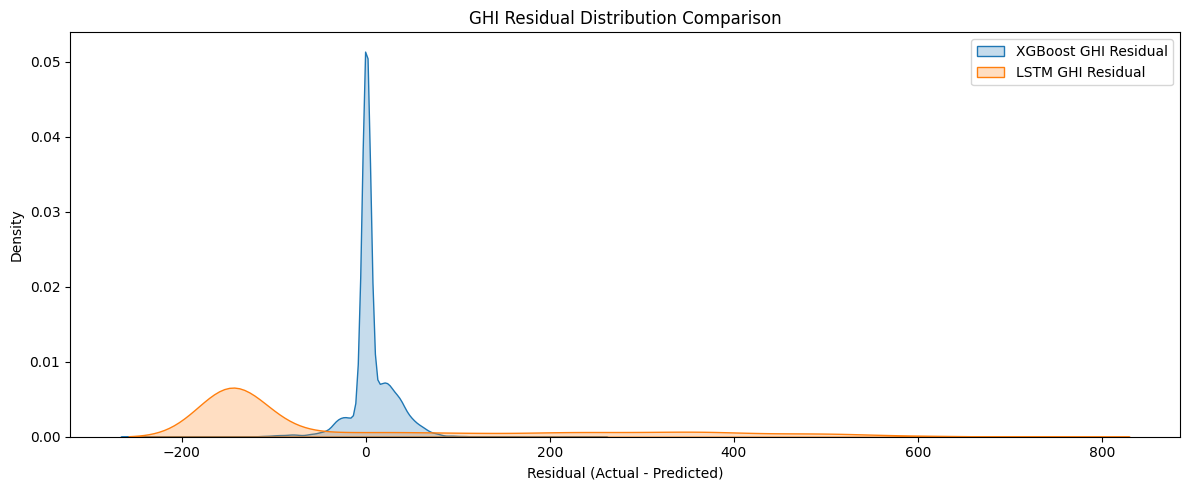

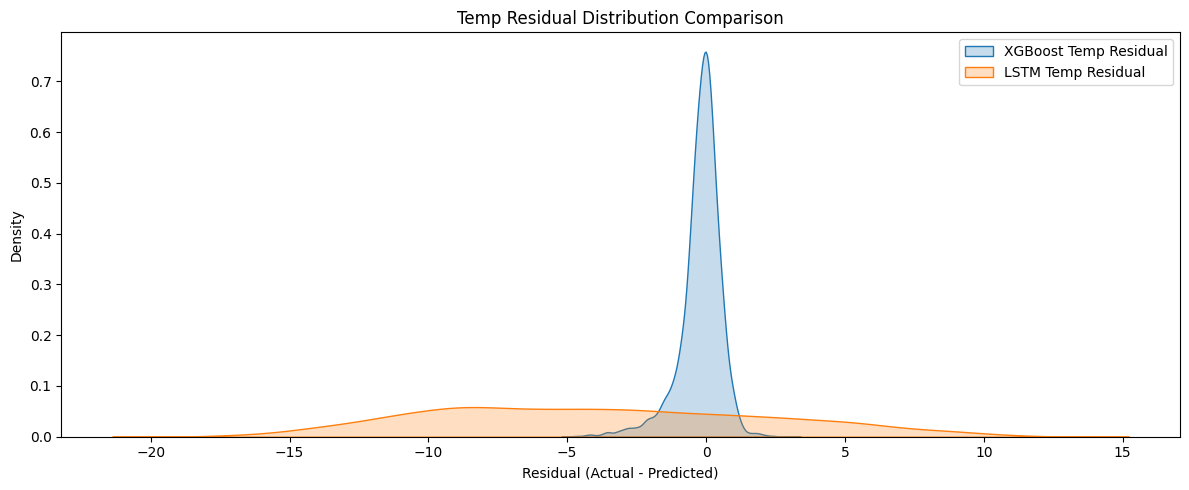

Saved comparison plots to: visualizations


In [16]:
# CELL 6 (Code): four-model diagnostics
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

viz_dir = Path("visualizations")
viz_dir.mkdir(parents=True, exist_ok=True)

# Align sequence-based predictions with timeline by trimming initial time_steps.
time_steps = 24
test_timestamps_seq = processed_sorted.loc[X_test.index, "Timestamp"].reset_index(drop=True).iloc[time_steps:]

comparison_ghi = pd.DataFrame(
    {
        "Timestamp": test_timestamps_seq.reset_index(drop=True),
        "Actual_GHI": pd.Series(y_test_seq_ghi).reset_index(drop=True),
        "XGBoost_GHI_Pred": pd.Series(xgb_ghi_preds).reset_index(drop=True).iloc[time_steps:].reset_index(drop=True),
        "LSTM_GHI_Pred": pd.Series(lstm_ghi_preds).reset_index(drop=True),
    }
)
comparison_temp = pd.DataFrame(
    {
        "Timestamp": test_timestamps_seq.reset_index(drop=True),
        "Actual_Temp": pd.Series(y_test_seq_temp).reset_index(drop=True),
        "XGBoost_Temp_Pred": pd.Series(xgb_temp_preds).reset_index(drop=True).iloc[time_steps:].reset_index(drop=True),
        "LSTM_Temp_Pred": pd.Series(lstm_temp_preds).reset_index(drop=True),
    }
)

comparison_ghi["XGB_GHI_Residual"] = comparison_ghi["Actual_GHI"] - comparison_ghi["XGBoost_GHI_Pred"]
comparison_ghi["LSTM_GHI_Residual"] = comparison_ghi["Actual_GHI"] - comparison_ghi["LSTM_GHI_Pred"]
comparison_temp["XGB_Temp_Residual"] = comparison_temp["Actual_Temp"] - comparison_temp["XGBoost_Temp_Pred"]
comparison_temp["LSTM_Temp_Residual"] = comparison_temp["Actual_Temp"] - comparison_temp["LSTM_Temp_Pred"]

summary_metrics = pd.DataFrame(
    [
        {"Model": "XGBoost_GHI", "MAE": float(xgb_ghi_mae), "RMSE": float(xgb_ghi_rmse)},
        {"Model": "XGBoost_Temp", "MAE": float(xgb_temp_mae), "RMSE": float(xgb_temp_rmse)},
        {"Model": "LSTM_GHI", "MAE": float(lstm_ghi_mae), "RMSE": float(lstm_ghi_rmse)},
        {"Model": "LSTM_Temp", "MAE": float(lstm_temp_mae), "RMSE": float(lstm_temp_rmse)},
    ]
)

print("Model performance summary:")
print(summary_metrics)

plt.figure(figsize=(12, 5))
sns.kdeplot(comparison_ghi["XGB_GHI_Residual"], label="XGBoost GHI Residual", fill=True)
sns.kdeplot(comparison_ghi["LSTM_GHI_Residual"], label="LSTM GHI Residual", fill=True)
plt.title("GHI Residual Distribution Comparison")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(viz_dir / "model_comparison_residuals_ghi.png", dpi=300)
plt.show()

plt.figure(figsize=(12, 5))
sns.kdeplot(comparison_temp["XGB_Temp_Residual"], label="XGBoost Temp Residual", fill=True)
sns.kdeplot(comparison_temp["LSTM_Temp_Residual"], label="LSTM Temp Residual", fill=True)
plt.title("Temp Residual Distribution Comparison")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(viz_dir / "model_comparison_residuals_temp.png", dpi=300)
plt.show()

print(f"Saved comparison plots to: {viz_dir}")

In [17]:
# CELL 7: Persist metrics payload (script-compatible)
import json
from datetime import UTC, datetime
from pathlib import Path

metrics_payload = {
    "trained_at_utc": datetime.now(UTC).isoformat(),
    "train_rows": int(len(X_train)),
    "test_rows": int(len(X_test)),
    "xgboost_ghi": {
        "model_name": "xgboost_ghi",
        "mae": float(xgb_ghi_mae),
        "rmse": float(xgb_ghi_rmse),
        "model_path": str(artifacts_dir / "xgboost_ghi_model.pkl"),
    },
    "xgboost_temp": {
        "model_name": "xgboost_temp",
        "mae": float(xgb_temp_mae),
        "rmse": float(xgb_temp_rmse),
        "model_path": str(artifacts_dir / "xgboost_temp_model.pkl"),
    },
    "lstm_ghi": {
        "model_name": "lstm_ghi",
        "mae": float(lstm_ghi_mae),
        "rmse": float(lstm_ghi_rmse),
        "model_path": str(artifacts_dir / "lstm_ghi_model.keras"),
    },
    "lstm_temp": {
        "model_name": "lstm_temp",
        "mae": float(lstm_temp_mae),
        "rmse": float(lstm_temp_rmse),
        "model_path": str(artifacts_dir / "lstm_temp_model.keras"),
    },
}

metrics_path = Path("artifacts/metrics_latest.json")
metrics_path.parent.mkdir(parents=True, exist_ok=True)
metrics_path.write_text(json.dumps(metrics_payload, indent=2), encoding="utf-8")

print(f"Saved metrics payload to: {metrics_path}")
print(json.dumps(metrics_payload, indent=2))

Saved metrics payload to: artifacts\metrics_latest.json
{
  "trained_at_utc": "2026-02-28T07:53:05.803326+00:00",
  "train_rows": 28512,
  "test_rows": 7128,
  "xgboost_ghi": {
    "model_name": "xgboost_ghi",
    "mae": 13.672266851911699,
    "rmse": 26.10268080732517,
    "model_path": "artifacts\\xgboost_ghi_model.pkl"
  },
  "xgboost_temp": {
    "model_name": "xgboost_temp",
    "mae": 0.5280158502886994,
    "rmse": 0.7873920256459197,
    "model_path": "artifacts\\xgboost_temp_model.pkl"
  },
  "lstm_ghi": {
    "model_name": "lstm_ghi",
    "mae": 182.72174072265625,
    "rmse": 217.96762768528265,
    "model_path": "artifacts\\lstm_ghi_model.keras"
  },
  "lstm_temp": {
    "model_name": "lstm_temp",
    "mae": 6.044596195220947,
    "rmse": 7.211996775613192,
    "model_path": "artifacts\\lstm_temp_model.keras"
  }
}
